# Modèle : ResNet-50 avec Transfer Learning

Utilise ResNet-50 pré-entraîné sur ImageNet avec:
- Transfer learning
- Fine-tuning progressif
- Grad-CAM pour l'explicabilité

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")

🖥️  Device: cpu


## 1. Dataset et DataLoader

In [3]:
class SpiceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        
        for class_name in self.class_names:
            class_dir = self.root_dir / class_name
            for img_path in class_dir.glob('*.jpg'):
                self.images.append(img_path)
                self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Transforms (ImageNet normalization)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Créer datasets
train_dataset = SpiceDataset('../dataset/splits/train', transform=train_transform)
val_dataset = SpiceDataset('../dataset/splits/val', transform=val_transform)
test_dataset = SpiceDataset('../dataset/splits/test', transform=val_transform)

print(f"📊 Train: {len(train_dataset)} images")
print(f"📊 Val: {len(val_dataset)} images")
print(f"📊 Test: {len(test_dataset)} images")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

📊 Train: 1540 images
📊 Val: 330 images
📊 Test: 330 images


## 2. Modèle ResNet-50 avec Transfer Learning

In [4]:
# Charger ResNet-50 pré-entraîné
model = models.resnet50(pretrained=True)

# Geler les couches de base
for param in model.parameters():
    param.requires_grad = False

# Remplacer la dernière couche
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 11)
)

model = model.to(device)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Total paramètres: {total_params:,}")
print(f"📊 Paramètres entraînables: {trainable_params:,}")
print(f"📊 Paramètres gelés: {total_params - trainable_params:,}")

c:\Users\zaineb\.conda\envs\spices_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zaineb\.conda\envs\spices_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\zaineb/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:05<00:00, 18.6MB/s]



📊 Total paramètres: 24,562,763
📊 Paramètres entraînables: 1,054,731
📊 Paramètres gelés: 23,508,032


## 3. Phase 1: Entraînement du Classifier

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [7]:
# Phase 1: Entraîner seulement le classifier
print("\n🔥 Phase 1: Entraînement du classifier (feature extractor gelé)")
num_epochs_phase1 = 15
best_val_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs_phase1):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{num_epochs_phase1}")
    print(f"{'='*50}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'model_resnet_phase1.pth')
        print(f"✅ Meilleur modèle sauvegardé! Val Acc: {val_acc:.2f}%")


🔥 Phase 1: Entraînement du classifier (feature extractor gelé)

Epoch 1/15


Training: 100%|██████████| 49/49 [06:00<00:00,  7.35s/it]


Train Loss: 1.3255 | Train Acc: 55.52%
Val Loss: 0.5564 | Val Acc: 85.15%
✅ Meilleur modèle sauvegardé! Val Acc: 85.15%

Epoch 2/15


Training: 100%|██████████| 49/49 [07:32<00:00,  9.24s/it]


Train Loss: 0.5964 | Train Acc: 81.69%
Val Loss: 0.3590 | Val Acc: 87.58%
✅ Meilleur modèle sauvegardé! Val Acc: 87.58%

Epoch 3/15


Training: 100%|██████████| 49/49 [07:00<00:00,  8.59s/it]


Train Loss: 0.5239 | Train Acc: 83.38%
Val Loss: 0.4385 | Val Acc: 85.15%

Epoch 4/15


Training: 100%|██████████| 49/49 [04:29<00:00,  5.51s/it]


Train Loss: 0.4532 | Train Acc: 84.68%
Val Loss: 0.3174 | Val Acc: 88.79%
✅ Meilleur modèle sauvegardé! Val Acc: 88.79%

Epoch 5/15


Training: 100%|██████████| 49/49 [04:41<00:00,  5.74s/it]


Train Loss: 0.4104 | Train Acc: 86.49%
Val Loss: 0.3044 | Val Acc: 88.79%

Epoch 6/15


Training: 100%|██████████| 49/49 [05:02<00:00,  6.17s/it]


Train Loss: 0.4243 | Train Acc: 85.65%
Val Loss: 0.3464 | Val Acc: 90.00%
✅ Meilleur modèle sauvegardé! Val Acc: 90.00%

Epoch 7/15


Training: 100%|██████████| 49/49 [04:18<00:00,  5.27s/it]


Train Loss: 0.3490 | Train Acc: 88.05%
Val Loss: 0.2503 | Val Acc: 91.52%
✅ Meilleur modèle sauvegardé! Val Acc: 91.52%

Epoch 8/15


Training: 100%|██████████| 49/49 [04:08<00:00,  5.07s/it]


Train Loss: 0.3463 | Train Acc: 88.90%
Val Loss: 0.2857 | Val Acc: 90.30%

Epoch 9/15


Training: 100%|██████████| 49/49 [04:07<00:00,  5.06s/it]


Train Loss: 0.3645 | Train Acc: 87.60%
Val Loss: 0.2382 | Val Acc: 91.82%
✅ Meilleur modèle sauvegardé! Val Acc: 91.82%

Epoch 10/15


Training: 100%|██████████| 49/49 [04:14<00:00,  5.20s/it]


Train Loss: 0.3762 | Train Acc: 89.03%
Val Loss: 0.2349 | Val Acc: 92.73%
✅ Meilleur modèle sauvegardé! Val Acc: 92.73%

Epoch 11/15


Training: 100%|██████████| 49/49 [04:14<00:00,  5.20s/it]


Train Loss: 0.3196 | Train Acc: 89.55%
Val Loss: 0.2866 | Val Acc: 88.18%

Epoch 12/15


Training: 100%|██████████| 49/49 [04:08<00:00,  5.08s/it]


Train Loss: 0.2950 | Train Acc: 89.81%
Val Loss: 0.2429 | Val Acc: 92.12%

Epoch 13/15


Training: 100%|██████████| 49/49 [04:08<00:00,  5.08s/it]


Train Loss: 0.3395 | Train Acc: 89.81%
Val Loss: 0.2900 | Val Acc: 90.30%

Epoch 14/15


Training: 100%|██████████| 49/49 [04:09<00:00,  5.10s/it]


Train Loss: 0.4478 | Train Acc: 87.14%
Val Loss: 0.2490 | Val Acc: 89.39%

Epoch 15/15


Training: 100%|██████████| 49/49 [04:07<00:00,  5.05s/it]


Train Loss: 0.2873 | Train Acc: 91.62%
Val Loss: 0.2018 | Val Acc: 91.52%


## 4. Phase 2: Fine-tuning

In [8]:
# Dégeler les dernières couches
print("\n🔥 Phase 2: Fine-tuning (dégel des dernières couches)")
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True

# Optimiseur avec learning rate plus petit
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 0.0001},
    {'params': model.fc.parameters(), 'lr': 0.001}
])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Paramètres entraînables (phase 2): {trainable_params:,}")


🔥 Phase 2: Fine-tuning (dégel des dernières couches)
📊 Paramètres entraînables (phase 2): 16,019,467


In [9]:
# Phase 2: Fine-tuning
num_epochs_phase2 = 15

for epoch in range(num_epochs_phase2):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{num_epochs_phase2} (Fine-tuning)")
    print(f"{'='*50}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'model_resnet_best.pth')
        print(f"✅ Meilleur modèle sauvegardé! Val Acc: {val_acc:.2f}%")


Epoch 1/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:31<00:00,  5.55s/it]


Train Loss: 0.3016 | Train Acc: 90.52%
Val Loss: 0.1746 | Val Acc: 95.15%
✅ Meilleur modèle sauvegardé! Val Acc: 95.15%

Epoch 2/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:18<00:00,  5.27s/it]


Train Loss: 0.1038 | Train Acc: 96.49%
Val Loss: 0.1233 | Val Acc: 96.97%
✅ Meilleur modèle sauvegardé! Val Acc: 96.97%

Epoch 3/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:27<00:00,  5.45s/it]


Train Loss: 0.1325 | Train Acc: 97.08%
Val Loss: 0.1066 | Val Acc: 97.58%
✅ Meilleur modèle sauvegardé! Val Acc: 97.58%

Epoch 4/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:35<00:00,  5.63s/it]


Train Loss: 0.1493 | Train Acc: 97.53%
Val Loss: 0.0586 | Val Acc: 97.27%

Epoch 5/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:34<00:00,  5.60s/it]


Train Loss: 0.1110 | Train Acc: 97.47%
Val Loss: 0.1111 | Val Acc: 97.58%

Epoch 6/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:35<00:00,  5.63s/it]


Train Loss: 0.0871 | Train Acc: 97.99%
Val Loss: 0.0781 | Val Acc: 97.58%

Epoch 7/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:35<00:00,  5.62s/it]


Train Loss: 0.0490 | Train Acc: 98.44%
Val Loss: 0.1485 | Val Acc: 97.27%

Epoch 8/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:35<00:00,  5.63s/it]


Train Loss: 0.1208 | Train Acc: 97.79%
Val Loss: 0.0924 | Val Acc: 96.97%

Epoch 9/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:36<00:00,  5.63s/it]


Train Loss: 0.0550 | Train Acc: 98.70%
Val Loss: 0.0860 | Val Acc: 97.58%

Epoch 10/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:36<00:00,  5.64s/it]


Train Loss: 0.0115 | Train Acc: 99.74%
Val Loss: 0.1218 | Val Acc: 97.88%
✅ Meilleur modèle sauvegardé! Val Acc: 97.88%

Epoch 11/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:38<00:00,  5.69s/it]


Train Loss: 0.0127 | Train Acc: 99.61%
Val Loss: 0.0449 | Val Acc: 97.88%

Epoch 12/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:38<00:00,  5.69s/it]


Train Loss: 0.0212 | Train Acc: 99.42%
Val Loss: 0.0510 | Val Acc: 98.48%
✅ Meilleur modèle sauvegardé! Val Acc: 98.48%

Epoch 13/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:46<00:00,  5.85s/it]


Train Loss: 0.0119 | Train Acc: 99.55%
Val Loss: 0.1000 | Val Acc: 97.88%

Epoch 14/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:41<00:00,  5.74s/it]


Train Loss: 0.0421 | Train Acc: 99.68%
Val Loss: 0.1334 | Val Acc: 97.58%

Epoch 15/15 (Fine-tuning)


Training: 100%|██████████| 49/49 [04:38<00:00,  5.69s/it]


Train Loss: 0.0508 | Train Acc: 99.09%
Val Loss: 0.0919 | Val Acc: 98.48%


## 5. Visualisation des Résultats

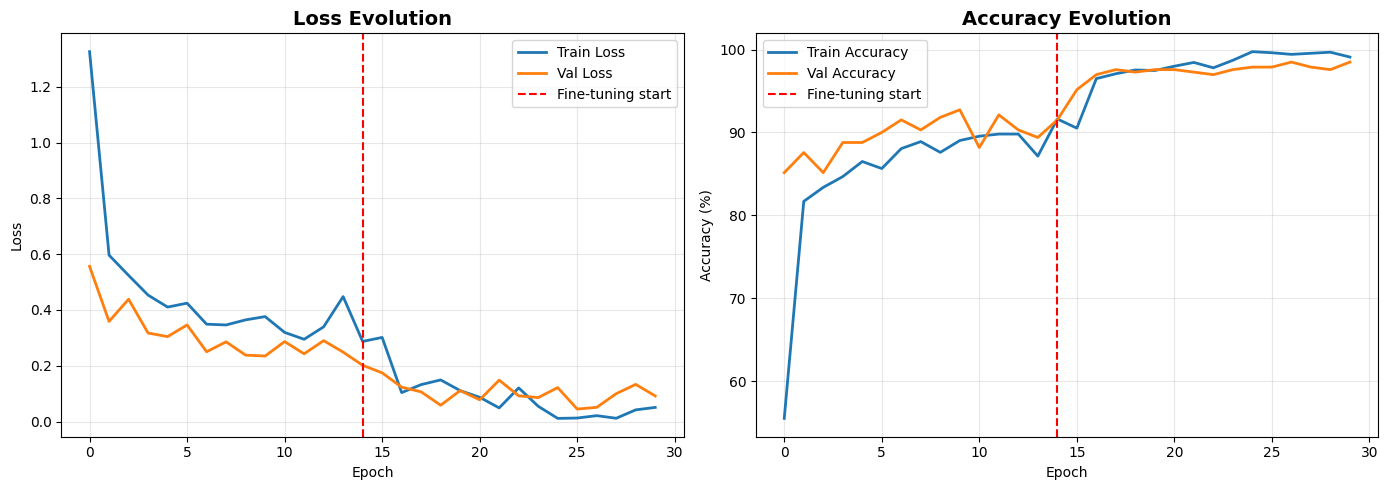

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].axvline(x=num_epochs_phase1-1, color='red', linestyle='--', label='Fine-tuning start')
axes[0].set_title('Loss Evolution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[1].axvline(x=num_epochs_phase1-1, color='red', linestyle='--', label='Fine-tuning start')
axes[1].set_title('Accuracy Evolution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Évaluation sur le Test Set


📊 Classification Report:
              precision    recall  f1-score   support

        anis       0.97      0.97      0.97        30
    cannelle       1.00      0.97      0.98        30
       carvi       1.00      1.00      1.00        30
clou_girofle       1.00      0.87      0.93        30
      cubebe       0.97      1.00      0.98        30
       cumin       0.94      0.97      0.95        30
     curcuma       1.00      1.00      1.00        30
   gingembre       1.00      1.00      1.00        30
     paprika       1.00      1.00      1.00        30
 poivre noir       0.88      0.97      0.92        30
      safran       1.00      1.00      1.00        30

    accuracy                           0.98       330
   macro avg       0.98      0.98      0.98       330
weighted avg       0.98      0.98      0.98       330



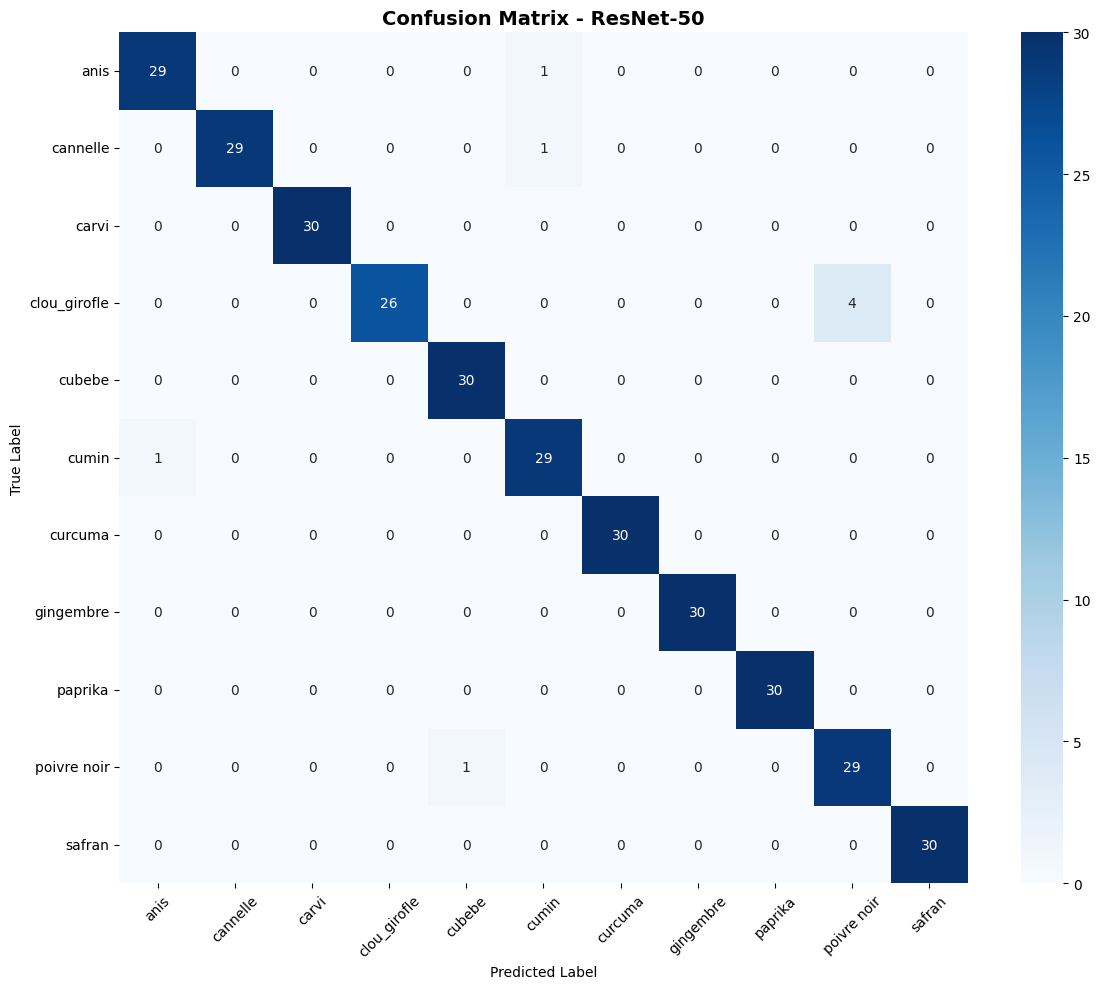

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Charger le meilleur modèle
checkpoint = torch.load('../models/model_resnet_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Évaluer
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.class_names,
            yticklabels=train_dataset.class_names)
plt.title('Confusion Matrix - ResNet-50', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Explainability: Grad-CAM pour ResNet

In [12]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate(self, image, class_idx):
        self.model.eval()
        image = image.unsqueeze(0).to(device)
        image.requires_grad = True
        
        # Forward
        output = self.model(image)
        
        # Backward
        self.model.zero_grad()
        output[0, class_idx].backward()
        
        # Compute CAM
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = np.maximum(cam, 0)
        cam = cam / cam.max() if cam.max() != 0 else cam
        cam = cv2.resize(cam, (224, 224))
        
        return cam

# Créer Grad-CAM
gradcam = GradCAM(model, model.layer4)

c:\Users\zaineb\.conda\envs\spices_env\lib\site-packages\torch\nn\modules\module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


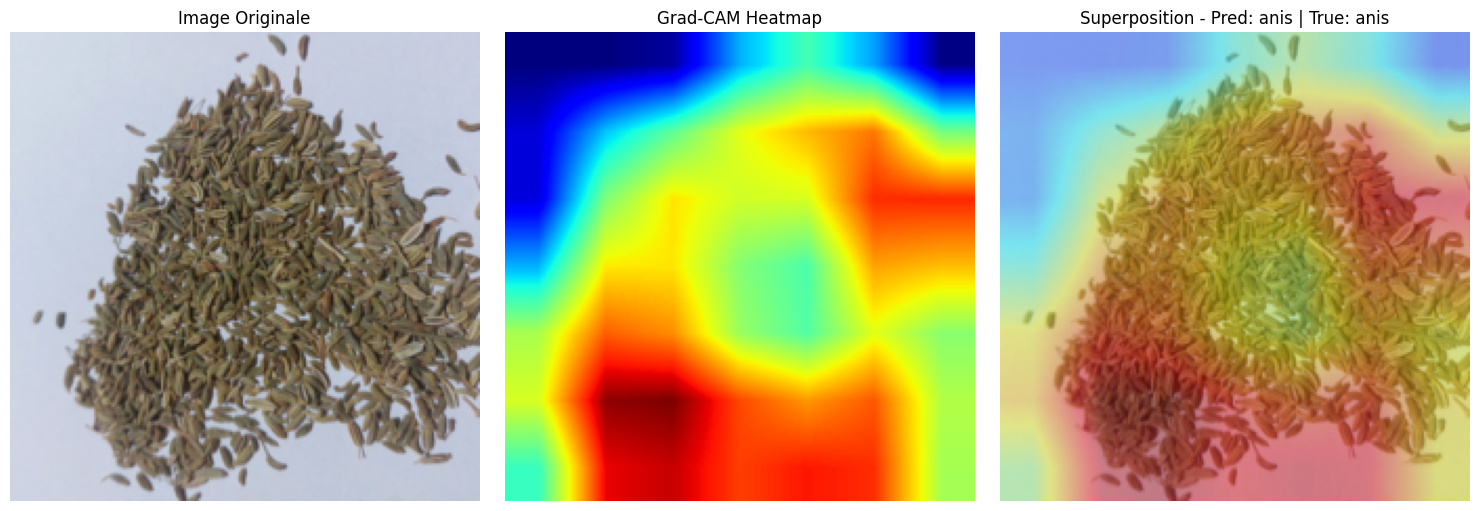

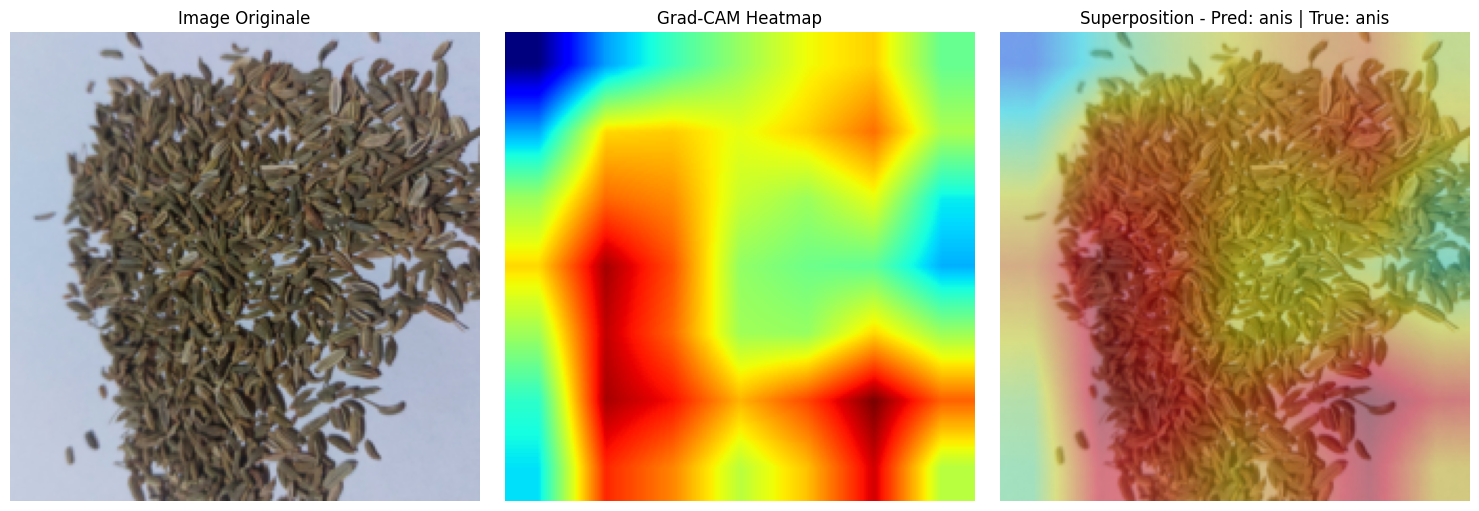

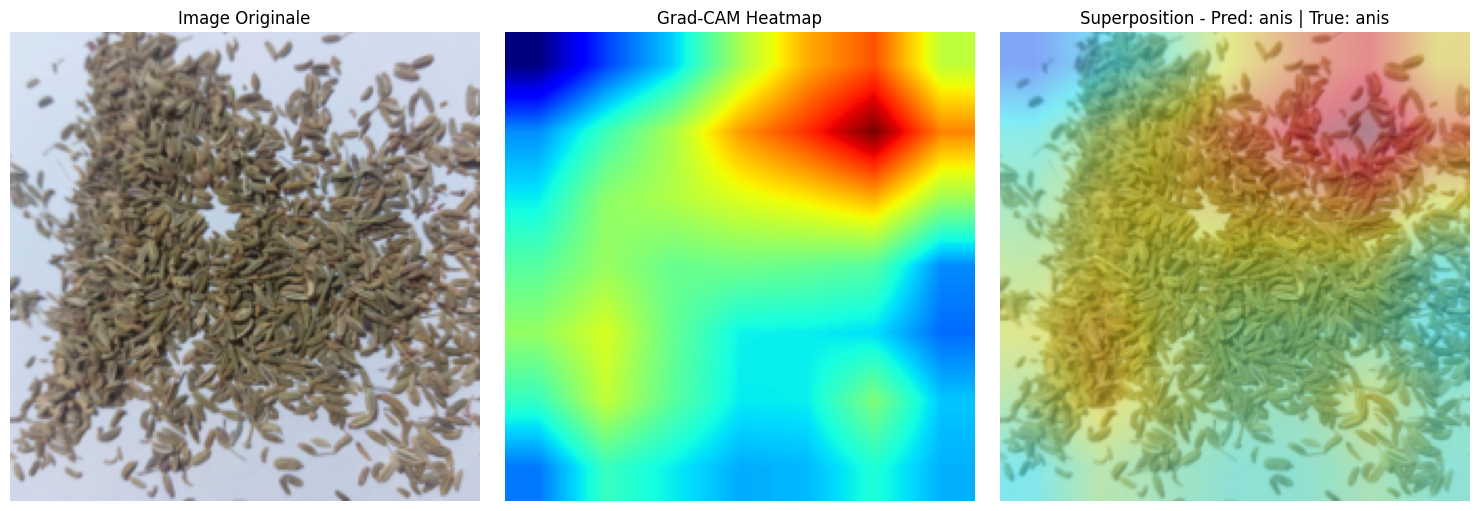

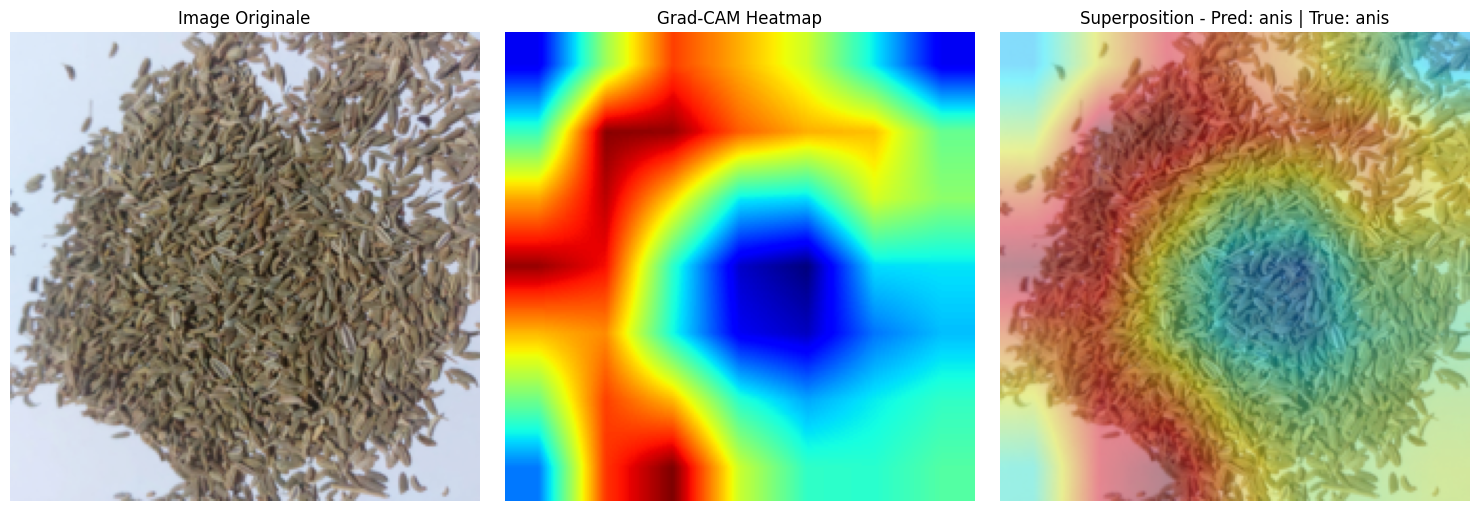

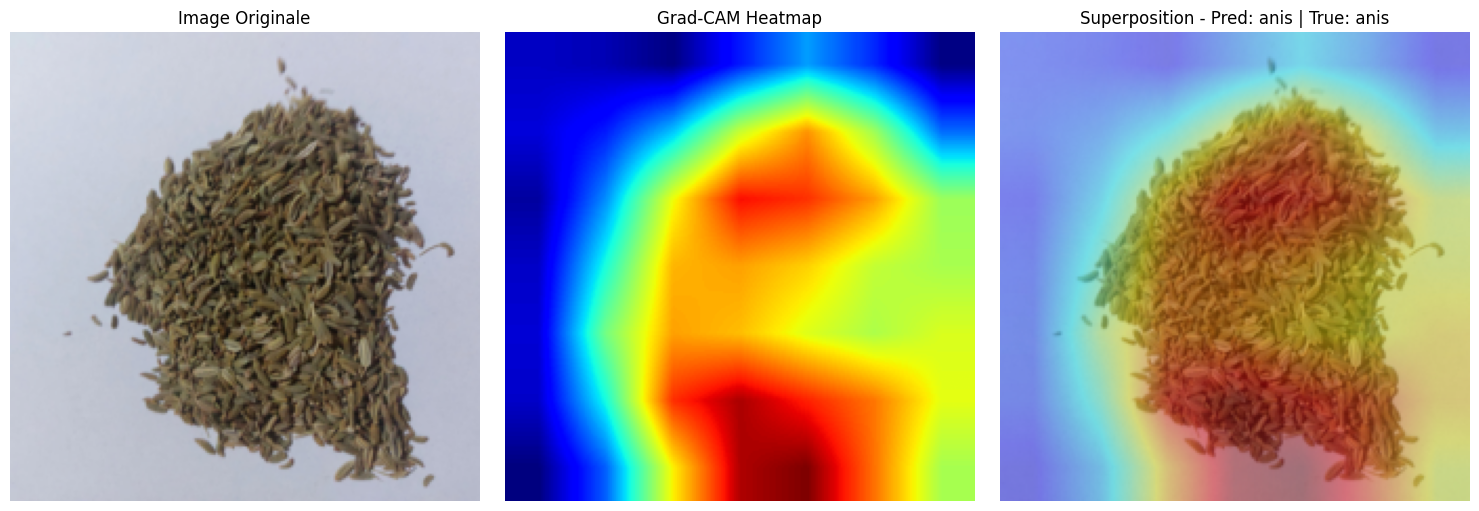

In [13]:
def show_gradcam(image, cam, title):
    # Dénormaliser l'image
    img = image.cpu().numpy().transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    # Créer heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Superposer
    overlay = 0.6 * img + 0.4 * heatmap
    overlay = np.clip(overlay, 0, 1)
    
    # Afficher
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title('Image Originale')
    axes[0].axis('off')
    
    axes[1].imshow(cam, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')
    
    axes[2].imshow(overlay)
    axes[2].set_title(f'Superposition - {title}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualiser sur quelques exemples
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(min(5, len(images))):
    image = images[i]
    label = labels[i].item()
    
    # Prédiction
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = output.argmax(1).item()
    
    # Générer Grad-CAM
    cam = gradcam.generate(image, pred)
    
    # Afficher
    title = f"Pred: {train_dataset.class_names[pred]} | True: {train_dataset.class_names[label]}"
    show_gradcam(image, cam, title)

## 8. Sauvegarde des Métriques

In [14]:
# Sauvegarder les résultats
results = {
    'model': 'ResNet-50',
    'best_val_acc': float(best_val_acc),
    'test_acc': float(100. * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)),
    'num_params': int(total_params),
    'trainable_params': int(trainable_params),
    'history': history
}

with open('results_resnet.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✅ Résultats sauvegardés dans results_resnet.json")
print(f"📊 Test Accuracy: {results['test_acc']:.2f}%")


✅ Résultats sauvegardés dans results_resnet.json
📊 Test Accuracy: 97.58%
